# Optimización de Rutas

## 1. Criación del Mapa

In [1]:
import numpy as np
import networkx as nx
from scipy.spatial import distance_matrix

In [2]:
def crear_grafo_mina(n_nodes, n_bloqueos=1, seed=42):
    """
    Crea un grafo geométrico donde algunos caminos están bloqueados.
    Los pesos de las aristas representan la distancia euclidiana.

    Retorna la matriz de distancias lista para el Hamiltoniano.
    """
    np.random.seed(seed)

    coords = np.random.rand(n_nodes, 2) * 100
    pos = {i: coords[i] for i in range(n_nodes)}

    dist_mat = distance_matrix(coords, coords)

    G = nx.complete_graph(n_nodes)
    nx.set_node_attributes(G, pos, "pos")

    lista_aristas = list(G.edges())
    indices_a_bloquear = np.random.choice(
        len(lista_aristas), size=n_bloqueos, replace=False
    )

    for i in indices_a_bloquear:
        u, v = lista_aristas[i]

        G.remove_edge(u, v)
        PENALTY = 9999.0
        dist_mat[u][v] = PENALTY
        dist_mat[v][u] = PENALTY

        print(f"> Bloqueo generado entre Ubicación {u} y {v}")

    for u, v in G.edges():
        G[u][v]["weight"] = dist_mat[u][v]

    return G, dist_mat, pos

In [3]:
import matplotlib.pyplot as plt

In [4]:
def plot_graph(G, pos):
    plt.figure(figsize=(6, 6))
    nx.draw(G, pos, with_labels=True, node_color="orange", node_size=800)
    plt.title("Mapa de la Mina")
    plt.show()

In [5]:
N = 8

> Bloqueo generado entre Ubicación 3 y 5
> Bloqueo generado entre Ubicación 1 y 5
> Bloqueo generado entre Ubicación 1 y 2
Grafo generado con 8 ubicaciones.
Ejemplo de distancia (Nodo 0 a Nodo 1): 50.17


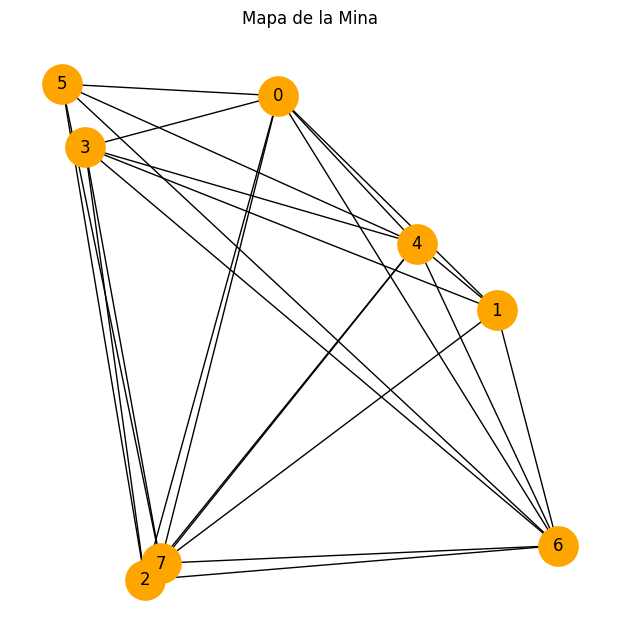

In [6]:
G_mina, matriz_distancias, posiciones = crear_grafo_mina(N, n_bloqueos=3)

print(f"Grafo generado con {N} ubicaciones.")
print("Ejemplo de distancia (Nodo 0 a Nodo 1):", f"{matriz_distancias[0][1]:.2f}")

plot_graph(G_mina, posiciones)

## 2. Programando el Problema Cuadrático

In [7]:
from dimod import BinaryQuadraticModel, BINARY
from typing import cast

In [8]:
def crear_hamiltoniano(
    dist_matrix: np.ndarray, A: float | None = None, B: float = 1.0
) -> BinaryQuadraticModel:
    """
    Construye el modelo BQM  para el problema de rutas.

    Args:
        dist_matrix (np.ndarray): Matriz N x N de distancias (con penalizaciones).
        A (float): Penalización por romper restricciones (Unicidad).
        B (float): Peso de la función de costo (Distancia).

    Returns:
        bqm (BinaryQuadraticModel): El modelo listo para resolver.
    """
    N = len(dist_matrix)

    max_dist = np.max(dist_matrix)
    if A is None:
        A = B * max_dist * 2.0
        print(f"Constante A calculada automáticamente: {A:.2f} (Max dist: {max_dist})")
    A = cast(float, A)

    bqm = BinaryQuadraticModel(BINARY)

    get_var = lambda i, t: f"x_{i}_{t}"

    for i in range(N):
        for t in range(N):
            var_name = get_var(i, t)
            bqm.add_variable(var_name, -2 * A)

    for t in range(N):
        for i in range(N):
            for j in range(i + 1, N):
                u = get_var(i, t)
                v = get_var(j, t)
                bqm.add_interaction(u, v, 2 * A)

    for i in range(N):
        for t in range(N):
            for k in range(t + 1, N):
                u = get_var(i, t)
                v = get_var(i, k)
                bqm.add_interaction(u, v, 2 * A)

    for t in range(N):
        next_t = (t + 1) % N

        for i in range(N):
            for j in range(N):
                if i != j:
                    dist = dist_matrix[i][j]

                    u = get_var(i, t)
                    v = get_var(j, next_t)

                    bqm.add_interaction(u, v, B * dist)

    return bqm

In [9]:
print("\n--- Construyendo Hamiltoniano ---")
bqm_mina = crear_hamiltoniano(matriz_distancias, A=None, B=1.0)

print(f"Modelo construido con {bqm_mina.num_variables} variables/qubits.")
print(f"Número de interacciones cuadráticas: {bqm_mina.num_interactions}")

var_salida = "x_0_0"
var_llegada = "x_1_1"
bias_cuadratico = bqm_mina.get_quadratic(var_salida, var_llegada)
distancia_real = matriz_distancias[0][1]

print("\nVerificación:")
print(f"Distancia física (0->1): {distancia_real}")
print(f"Acoplamiento J en BQM ({var_salida}, {var_llegada}): {bias_cuadratico}")


--- Construyendo Hamiltoniano ---
Constante A calculada automáticamente: 19998.00 (Max dist: 9999.0)
Modelo construido con 64 variables/qubits.
Número de interacciones cuadráticas: 896

Verificación:
Distancia física (0->1): 50.17136010769449
Acoplamiento J en BQM (x_0_0, x_1_1): 50.17136010769449
